# Figure 6: Depth-Integrated Ocean Heat Content trends regressed on Aerosol Forcing Strength

This notebook will reproduce Figure 6 from *Ocean Heat Content responses to changing Anthropogenic Aerosol Forcing Strength: regional and multi-decadal variability*, E. Boland et al. 2022 ([pre-print](https://doi.org/10.1002/essoar.10511062.1)). This will require utils.py (expects to find it in ../code) and input datafiles (expects to find them in ../data_in) to run - please see the README for details.

The data files loaded were created as follows:
- Time series of depth-integrated OHC for the SMURPHS ensemble and the pre-industrial control were generated by running ohc_xy.py and ohc_xy_pic.py
- PIC drift was calculated in ohc_xy_pic_drift.py
- 30 year trends were calculated, de-drifted, then regridded to 1x1 deg in ohc_xy_trends.py, producing ohc_xy_trend_regrid_by_run\_\[ystart\]\[yend\].nc

Please attribute any plots or code from this notebook using the DOI from Zenodo: [10.5281/zenodo.6418479](https://doi.org/10.5281/zenodo.6418479)

E Boland Aug 2022 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import stats
sys.path.insert(0,'../code/')
import utils

In [2]:
# Directories for saving plots and finding input data
figs_dir = '../figs/' # Where you want the plots saved
data_dir='../data_in/' # Where the input data is (see README)

# Experiment info, don't alter
exps=['hist-0p2','hist-0p4','hist-0p7','hist-1p0','hist-1p5']
runs=['r1i1p1f2','r2i1p1f2','r3i1p1f2','r4i1p1f2','r5i1p1f2']
exp_names=['0.2','0.4','0.7','1.0','1.5']
y_start=[1960,1980]
y_end=[1991,2011]
forc=xr.DataArray(coords={'exp':exps},data=[0.38,0.6,0.93,1.17,1.5],dims=['exp'],)

In [3]:
ohu_xy=[]
for tchunk in range(0,2):
    ohc_runs=xr.open_dataarray(data_dir+'ohc_xy/ohc_xy_trend_regrid_byrun_'+str(y_start[tchunk])+str(y_end[tchunk])+'.nc')
    ohu_xy.append(ohc_runs)
ohu_xy=xr.concat(ohu_xy,'time')

In [4]:
# Plotting choices
atllims=[-60,15,35,80]
solims=[-90,-30]
atl_inds=(ohu_xy.lon>atllims[0])&(ohu_xy.lon<atllims[1])&(ohu_xy.lat>atllims[2])&(ohu_xy.lat<atllims[3])
so_inds=(ohu_xy.lat>solims[0])&(ohu_xy.lat<solims[1])
region_dict={'atl':{'inds':[atl_inds],'proj':ccrs.Orthographic(),'clims':[-20,20],'figsize':[15,3]},
            'so':{'inds':[so_inds],'proj':ccrs.SouthPolarStereo(),'clims':[-10,10],'figsize':[15,5]},
            'global':{'inds':None,'proj':ccrs.Robinson(central_longitude=-100),'clims':[-10,10],'figsize':[14,3]}}

regions=list(region_dict.keys()) 

In [5]:
all_stats=utils.lin_regress(forc.broadcast_like(ohu_xy).stack(exp_run=('exp','run')),ohu_xy.stack(exp_run=('exp','run')),[['exp_run'],['exp_run']])
slopes= all_stats.sel(parameter='slope')/1e7*12
t_score=all_stats.sel(parameter='r_value')*np.sqrt(25-2)/np.sqrt(1-all_stats.sel(parameter='r_value')**2)
tpval = stats.t.sf(np.abs(t_score),25-1)
sigs = slopes.copy(data=tpval<=0.05)

Text(0.5, 1.02, 'Ocean Heat Content trends regression on AA forcing')

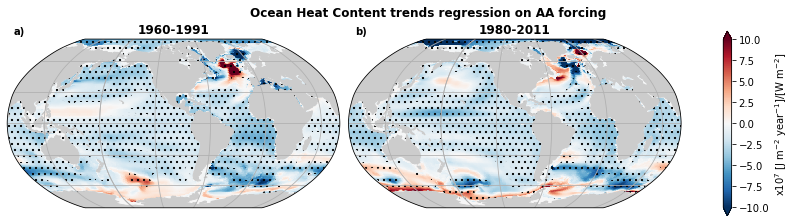

In [6]:
%matplotlib inline

region='global'

p=slopes.plot(x='lon',y='lat',col='time',transform=ccrs.PlateCarree(),
                   figsize=(12,3),
                    vmin=region_dict[region]['clims'][0],vmax=region_dict[region]['clims'][1],cbar_kwargs={'label': 'x10$^7$ [J m$^{-2}$ year$^{-1}$]/[W m$^{-2}$]'},
                  cmap='RdBu_r',rasterized=True,subplot_kws={'projection': region_dict[region]['proj']})
for ia,ax in enumerate(p.axes.flat):
    ax.gridlines()
    ax.add_feature(cf.LAND,color=[0.8,0.8,0.8],zorder=1)
    sigs.isel(time=ia).plot.contourf(x='lon',y='lat',alpha=0,levels=[-1,0,1],hatches=[None,'..'],transform=ccrs.PlateCarree(),add_colorbar=False,ax=ax)
    ax.text(0.02,1.03,'{})'.format(chr(ord('a')+ia)),fontweight='bold',transform=ax.transAxes)
    ax.set_title(str(y_start[ia])+'-'+str(y_end[ia]),fontweight='bold')

plt.suptitle('Ocean Heat Content trends regression on AA forcing',weight='bold',y=1.02)
plt.savefig(figs_dir+'Fig6_ohc_xy_regress_{}.png'.format(region),bbox_inches='tight')